# MNIST Diffuser

## General imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
def load_mnist_images(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    # Open the file in binary mode
    with open(file_path, 'rb') as f:
        # Read the magic number and dimensions (metadata)
        magic_number = int.from_bytes(f.read(4), byteorder='big')
        num_images = int.from_bytes(f.read(4), byteorder='big')
        num_rows = int.from_bytes(f.read(4), byteorder='big')
        num_cols = int.from_bytes(f.read(4), byteorder='big')

        # Calculate the total number of pixels per image
        num_pixels = num_rows * num_cols

        # Read the image data
        images = np.frombuffer(f.read(), dtype=np.uint8)

        # Reshape the data to (num_images, num_pixels)
        images = images.reshape((num_images, num_pixels))

    return images

def load_mnist_labels(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    # Open the file in binary mode
    with open(file_path, 'rb') as f:
        # Read the magic number and number of labels (metadata)
        magic_number = int.from_bytes(f.read(4), byteorder='big')
        num_labels = int.from_bytes(f.read(4), byteorder='big')

        # Read the label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)

    return labels

def filter_images_by_label(images, labels, target_label):
    # Get indices of images with the target label
    target_indices = np.where(labels == target_label)[0]

    # Filter the images and labels
    filtered_images = images[target_indices, :]
    filtered_labels = labels[target_indices]

    return filtered_images, filtered_labels

## Load training data

In [3]:
# Load Mnist dataset
#x_file="/data/mnist/train-images-idx3-ubyte"
x_file = "/home/mf/Documents/TAGI-V/cuTAGI/data/mnist/train-images-idx3-ubyte"
y_file = "/home/mf/Documents/TAGI-V/cuTAGI/data/mnist/train-labels-idx1-ubyte"

images = load_mnist_images(x_file)
labels = load_mnist_labels(y_file)

target_label = 8
x, _ = filter_images_by_label(images, labels, target_label)

#x = images shuffle
x = np.random.permutation(images)
# x = images

x = (x - x.mean()) / x.std()

print(x.shape)

(60000, 784)


## Prepare data for learning

In [4]:
import torch

X = torch.tensor(x, dtype=torch.float32)

## Diffusion model hyperparameters

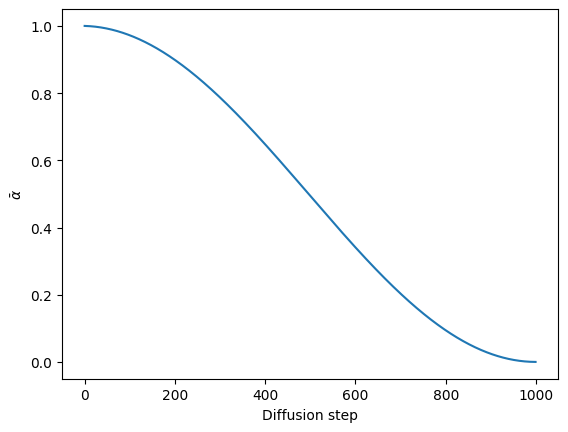

In [5]:
diffusion_steps = 1000  # Number of steps in the diffusion process

# Set noising variances betas as in Nichol and Dariwal paper (https://arxiv.org/pdf/2102.09672.pdf)
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas

# Check the cumulative alphas follow the distribution recommended in the paper
sns.lineplot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

Function that noises a data point following the diffusion process

In [6]:
def noise(Xbatch, t):
    eps = torch.randn(size=Xbatch.shape)
    noised = (baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + ((1 - baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
    return noised, eps

## Diffusion network

Now we define a pytorch network that will learn to predict the noise component from noised data.

In [7]:
import torch
import torch.nn as nn

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.layer = nn.Sequential(
            nn.Linear(1, dim),
            nn.SiLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, t):
        return self.layer(t)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.time_mlp = nn.Linear(time_dim, out_channels)
        self.act = nn.SiLU()

    def forward(self, x, t):
        h = self.act(self.norm1(self.conv1(x)))
        time_emb = self.act(self.time_mlp(t))[:, :, None, None]
        h = h + time_emb
        h = self.act(self.norm2(self.conv2(h)))
        return h

In [8]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = x
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += self.shortcut(residual)
        x = torch.relu(x)
        return x

class ResNetDiffusion(nn.Module):
    def __init__(self, input_channels=1, output_channels=1, num_residual_blocks=4):
        super(ResNetDiffusion, self).__init__()

        self.initial_conv = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.initial_bn = nn.BatchNorm1d(64)

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(64, 64) for _ in range(num_residual_blocks)]
        )

        self.final_conv = nn.Conv1d(64, output_channels, kernel_size=3, padding=1)

        self.time_embedding = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 64)
        )

    def forward(self, x, t):
        # x shape: [512, 784]
        # t shape: [512, 1]
        x = x.float()
        t = t.float()

        # Reshape x to [512, 1, 784] for 1D convolutions
        x = x.unsqueeze(1)

        # Initial convolution
        x = torch.relu(self.initial_bn(self.initial_conv(x)))

        # Time embedding
        t_emb = self.time_embedding(t)
        t_emb = t_emb.unsqueeze(-1).repeat(1, 1, x.shape[-1])

        # Add time embedding to feature map
        x = x + t_emb

        # Residual blocks
        x = self.res_blocks(x)

        # Final convolution
        x = self.final_conv(x)

        # Reshape output to [512, 784]
        x = x.squeeze(1)

        return x

In [9]:
import torch.nn as nn

class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x


class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()

        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_timestep=10000):
        super(SinusoidalPositionalEmbedding, self).__init__()
        self.dim = dim
        self.max_timestep = max_timestep

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(self.max_timestep) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t * emb
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.decoder(x)

class DiffusionAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, diffusion_steps):
        super(DiffusionAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim + latent_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)
        self.timestep_embedding = SinusoidalPositionalEmbedding(latent_dim)
        self.diffusion_steps = diffusion_steps

    def forward(self, x, t):
        # Get sinusoidal embeddings for timestep
        t_emb = self.timestep_embedding(t.float() / self.diffusion_steps)
        t_emb = t_emb.expand(x.size(0), -1)  # Expand to match batch size
        x = torch.hstack([x, t_emb])
        z = self.encoder(x)
        reconstructed_x = self.decoder(z)
        return reconstructed_x


In [11]:
# import torch
# import torch.nn as nn

# class SinusoidalPositionalEmbedding(nn.Module):
#     def __init__(self, dim, max_timestep=10000):
#         super(SinusoidalPositionalEmbedding, self).__init__()
#         self.dim = dim
#         self.max_timestep = max_timestep

#     def forward(self, t):
#         device = t.device
#         half_dim = self.dim // 2
#         emb = math.log(self.max_timestep) / (half_dim - 1)
#         emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
#         emb = t * emb
#         emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
#         return emb


# class UNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.time_dim = 256
#         self.time_mlp = SinusoidalPositionalEmbedding(self.time_dim)

#         # Input projection
#         self.input_proj = nn.Linear(784, 28*28)

#         # Encoder
#         self.down1 = ConvBlock(1, 64, self.time_dim)
#         self.down2 = ConvBlock(64, 128, self.time_dim)
#         self.down3 = ConvBlock(128, 256, self.time_dim)

#         # Bottleneck
#         self.bottleneck = ConvBlock(256, 512, self.time_dim)

#         # Decoder
#         self.up3 = ConvBlock(512 + 256, 256, self.time_dim)
#         self.up2 = ConvBlock(256 + 128, 128, self.time_dim)
#         self.up1 = ConvBlock(128 + 64, 64, self.time_dim)

#         # Output projection
#         self.output = nn.Conv2d(64, 1, 1)

#     def forward(self, x, t):
#         # Ensure x and t are float32
#         x = x.float()
#         t = t.float()

#         x = self.input_proj(x).view(-1, 1, 28, 28)
#         t = self.time_mlp(t / diffusion_steps)

#         # Encoder
#         d1 = self.down1(x, t)
#         d2 = self.down2(nn.functional.max_pool2d(d1, 2), t)
#         d3 = self.down3(nn.functional.max_pool2d(d2, 2), t)

#         # Bottleneck
#         bottleneck = self.bottleneck(nn.functional.max_pool2d(d3, 2), t)

#         # Decoder
#         u3 = self.up3(torch.cat([d3, nn.functional.interpolate(bottleneck, size=d3.shape[2:], mode='nearest')], dim=1), t)
#         u2 = self.up2(torch.cat([d2, nn.functional.interpolate(u3, size=d2.shape[2:], mode='nearest')], dim=1), t)
#         u1 = self.up1(torch.cat([d1, nn.functional.interpolate(u2, size=d1.shape[2:], mode='nearest')], dim=1), t)

#         # Output
#         output = self.output(u1)
#         return output.view(-1, 784)

In [12]:
import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

from labml_helpers.module import Module

class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x


class Swish(Module):
    """
    ### Swish activation function

    $$x \cdot \sigma(x)$$
    """

    def forward(self, x):
        return x * torch.sigmoid(x)


class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        # self.act = Swish()
        self.act = nn.ReLU()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings
        # [same as those from the transformer](../../transformers/positional_encoding.html)
        #
        # \begin{align}
        # PE^{(1)}_{t,i} &= sin\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg) \\
        # PE^{(2)}_{t,i} &= cos\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg)
        # \end{align}
        #
        # where $d$ is `half_dim`
        # half_dim = self.n_channels // 8
        half_dim = self.n_channels // 2
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        # emb = self.act(self.lin1(emb))
        # emb = self.lin2(emb)

        t_normalized = t / 1000

        # Expand the normalized timestep to match `n_channels`
        # This results in a tensor of shape `(batch_size, n_channels)`
        emb = t_normalized[:, None].expand(-1, self.n_channels)

        #
        return emb


class ResidualBlock(Module):
    """
    ### Residual block

    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int,
                 n_groups: int = 32, dropout: float = 0.1):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        * `dropout` is the dropout rate
        """
        super().__init__()
        # Group normalization and the first convolution layer
        # self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.norm1 = LayerNorm2d(in_channels)
        # self.norm1 = nn.BatchNorm2d(in_channels)

        # self.act1 = Swish()
        self.act1 = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        # self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.norm2 = LayerNorm2d(out_channels)
        # self.norm2 = nn.BatchNorm2d(out_channels)

        # self.act2 = Swish()
        self.act2 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_proj = nn.Conv2d(time_channels, out_channels, kernel_size=(1, 1))
        # self.time_act = Swish()
        self.time_act = nn.ReLU()
        # self.time_act = nn.Sigmoid()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # h = self.conv1(self.act1(x))

        if t.ndim == 2:
            t = t[:, :, None, None]  # Reshape to [batch_size, time_channels, 1, 1]

        # Add time embeddings
        h += self.time_proj(t)
        # Second convolution layer
        # h = self.conv2(self.dropout(self.act2(self.norm2(h))))
        h = self.conv2(self.act2(self.norm2(h)))
        # h = self.conv2(self.act2(h))


        # Add the shortcut connection and return
        return h + self.shortcut(x)


class AttentionBlock(Module):
    """
    ### Attention block

    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=2)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(Module):
    """
    ### Down block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(Module):
    """
    ### Up block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        #self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(Module):
    """
    ### Middle block

    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class UNet(Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[bool]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        # self.norm = nn.GroupNorm(8, n_channels)
        self.norm = LayerNorm2d(n_channels)
        # self.norm = nn.BatchNorm2d(n_channels)
        # self.act = Swish()
        self.act = nn.ReLU()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                # x = torch.cat((x, s), dim=1)
                #
                if x.shape == s.shape:
                    x = x + s
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))
        # return self.final(self.act(x))


Let's create a model with 4 inner blocks, which is enough for this problem.

In [13]:
# model = DiffusionModel(nfeatures=28*28, nblocks=1, nunits=6000)
# model = DiffusionAutoencoder(input_dim=28*28, latent_dim=64, diffusion_steps=diffusion_steps)
# model = UNet()
# model = ResNetDiffusion()

from easydict import EasyDict

args = {
    "image_channels": 1,  # Number of channels in the image. 3 for RGB.
    "image_size": 32,  # Image size
    "n_channels": 64,  # Number of channels in the initial feature map
    "channel_multipliers": [
        1,
        2,
        # 2,
        # 4,
    ],  # The list of channel numbers at each resolution.
    "is_attention": [
        False,
        False,
        # False,
        # False,
    ],  # The list of booleans for attention at each resolution
    "n_steps": 1000,  # Number of time steps T
    "nb_save": 5,  # Number of images to save
    "batch_size": 512,  # Batch size
    "n_samples": 16,  # Number of samples to generate
    "learning_rate": 2e-5,  # Learning rate
    "epochs": 20,  # Number of training epochs
    "device": "cuda" if torch.cuda.is_available() else "cpu",  # Device
    "fp16_precision": False
}
args = EasyDict(args)

model = UNet(
    image_channels=args.image_channels,
    n_channels=args.n_channels,
    ch_mults=args.channel_multipliers,
    is_attn=args.is_attention,
)

device = "cuda"
model = model.to(device)

model

UNet(
  (image_proj): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_emb): TimeEmbedding(
    (lin1): Linear(in_features=64, out_features=256, bias=True)
    (act): ReLU()
    (lin2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down): ModuleList(
    (0-1): 2 x DownBlock(
      (res): ResidualBlock(
        (norm1): LayerNorm2d()
        (act1): ReLU()
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): LayerNorm2d()
        (act2): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
        (time_emb): Linear(in_features=256, out_features=64, bias=True)
        (time_proj): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        (time_act): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attn): Identity()
    )
    (2): Downsample(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=

## Train denoising network

In [14]:
def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        x = x.view(-1, 1, 16, 16)
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            timesteps = torch.full([nsamples, 1], t).to(device)
            timesteps = timesteps.view(-1)
            predicted_noise = model(x, timesteps)

            predicted_noise = predicted_noise.to('cpu')
            x = x.to('cpu')

            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise)
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                nu = std * torch.randn(size=(nsamples, nfeatures))
                nu = nu.view(-1, 1, 16, 16)
                x += nu
            x = x.to(device)
            xt += [x]
        return x, xt

Epoch 0 loss = 0.3373587429523468


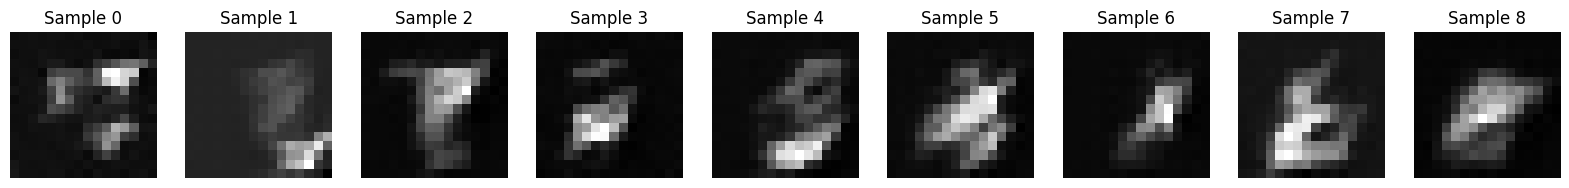

Epoch 1 loss = 0.1727374643087387


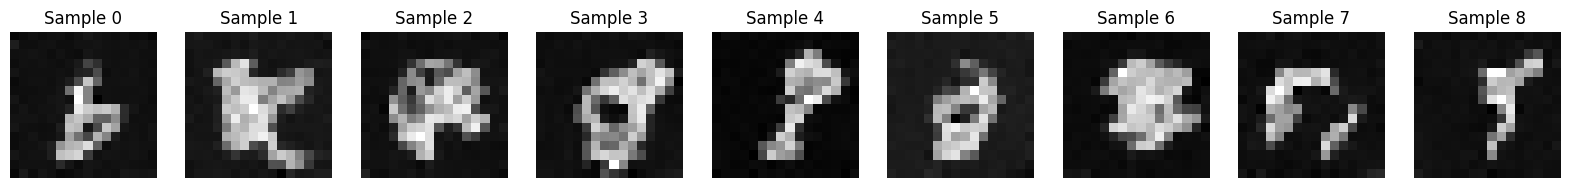

Epoch 2 loss = 0.13792426884174347


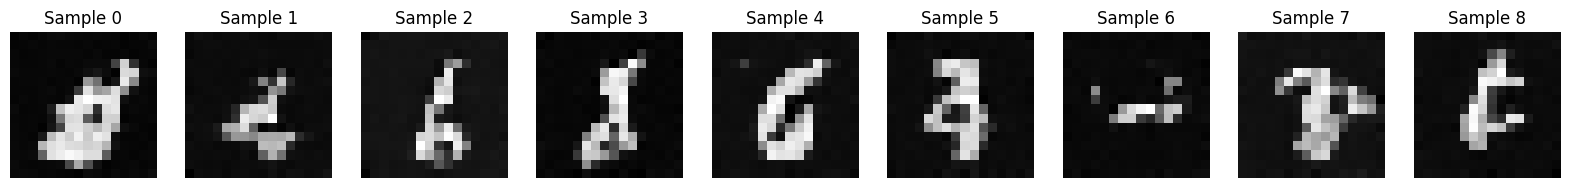

Epoch 3 loss = 0.1234961748123169


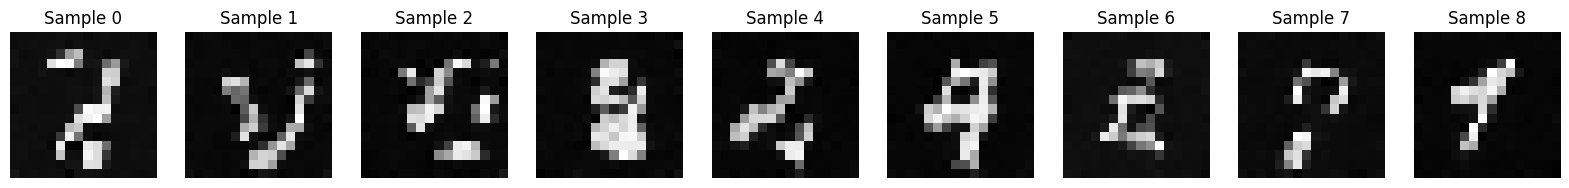

Epoch 4 loss = 0.11571355164051056


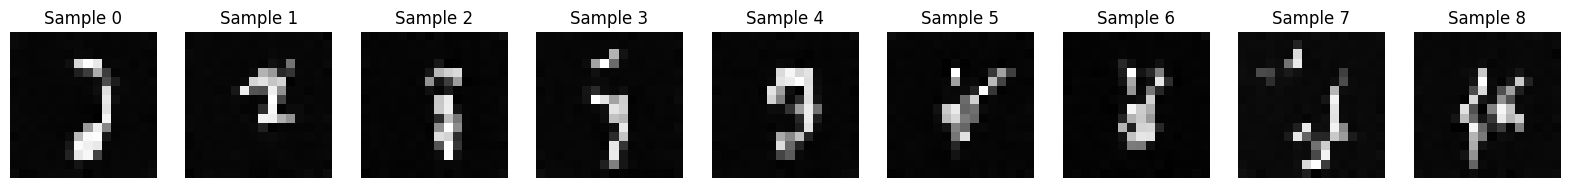

Epoch 5 loss = 0.1115589290857315


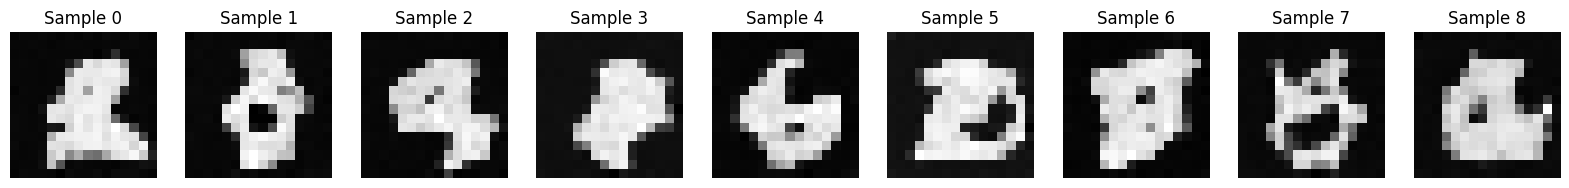

Epoch 6 loss = 0.10816425830125809


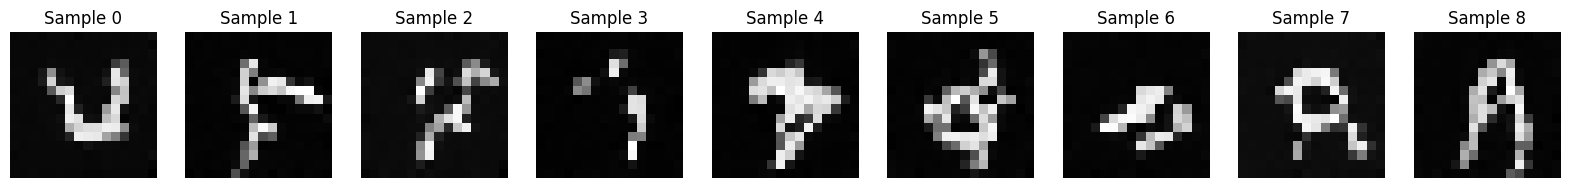

Epoch 7 loss = 0.10471704602241516


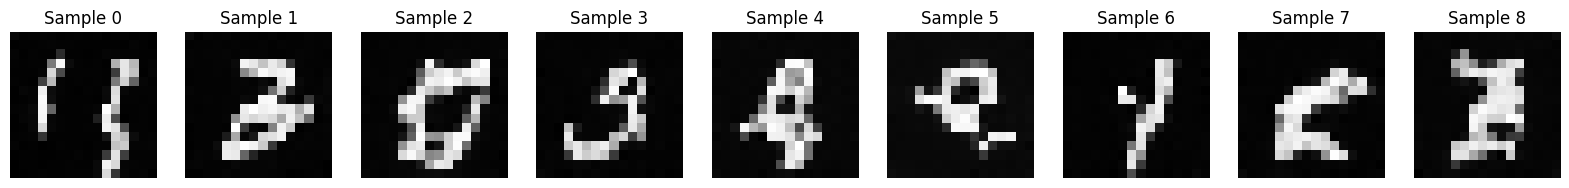

Epoch 8 loss = 0.10354950278997421


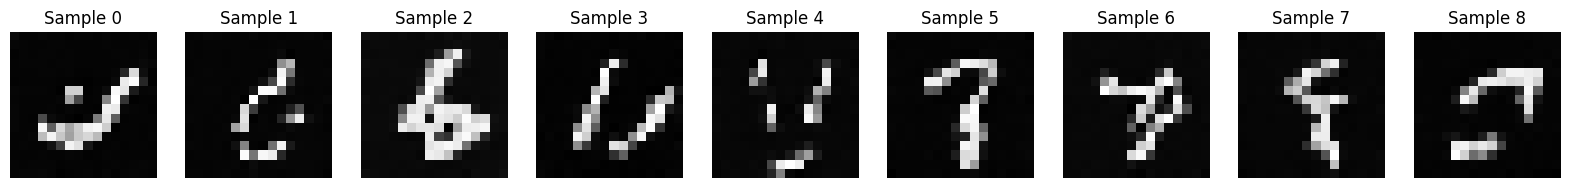

Epoch 9 loss = 0.10116662085056305


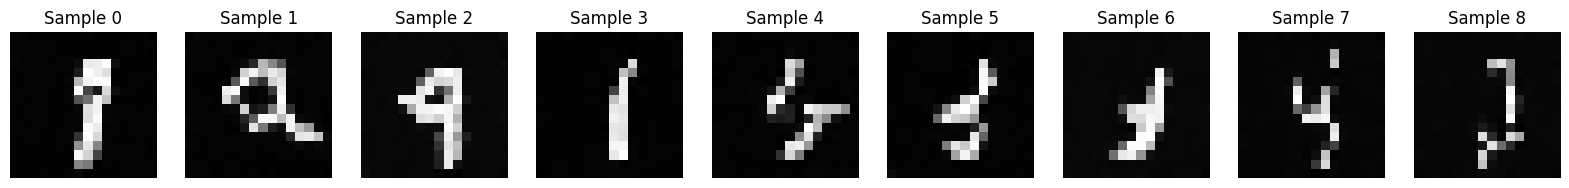

Epoch 10 loss = 0.09920099377632141


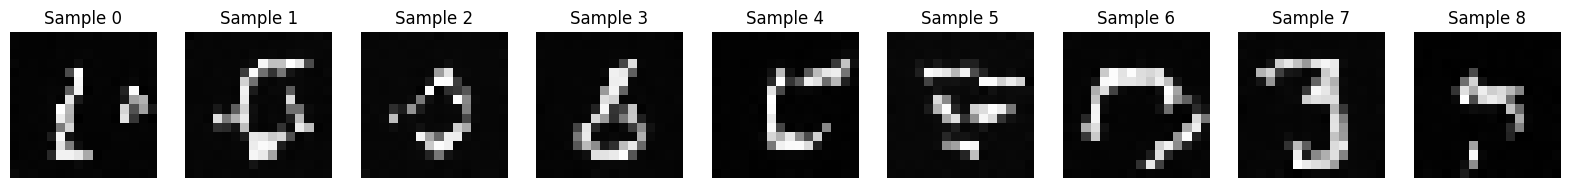

Epoch 11 loss = 0.09784701466560364


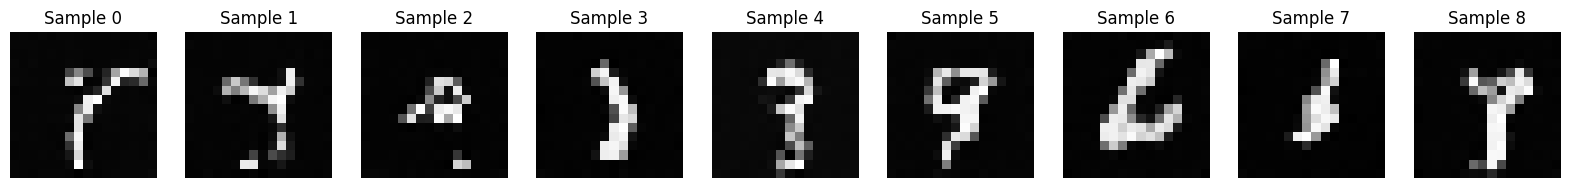

Epoch 12 loss = 0.0959215834736824


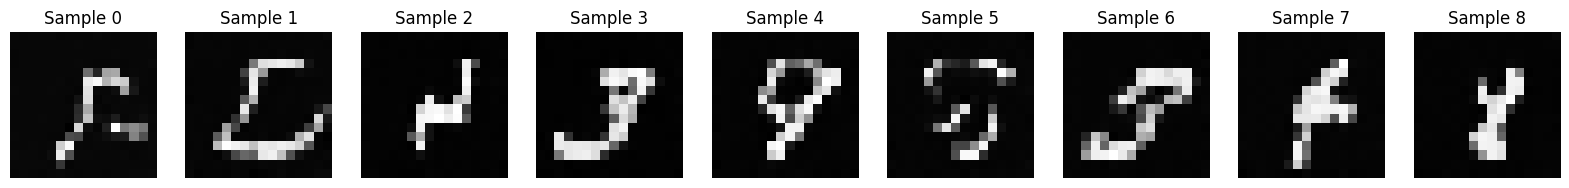

Epoch 13 loss = 0.09523547440767288


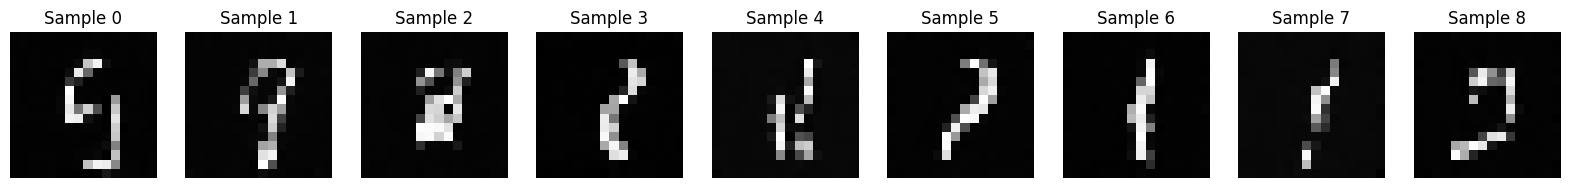

Epoch 14 loss = 0.09402844309806824


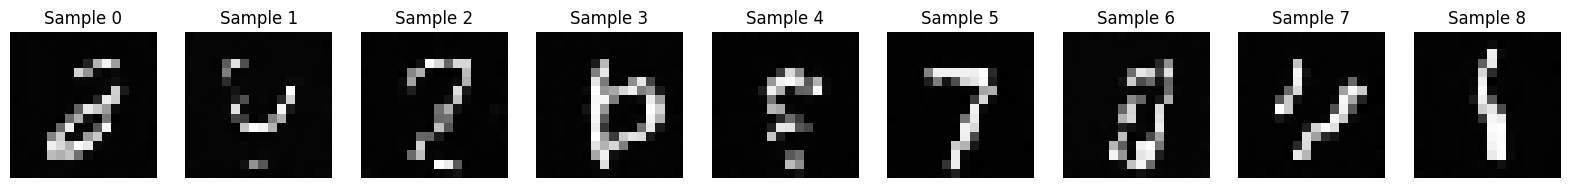

Epoch 15 loss = 0.09354005753993988


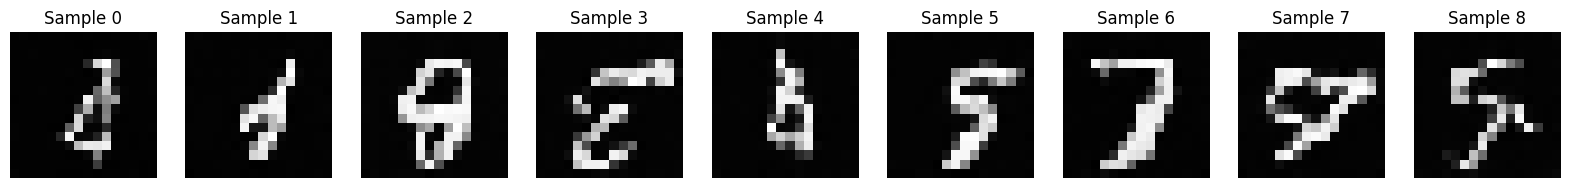

Epoch 16 loss = 0.09262978285551071


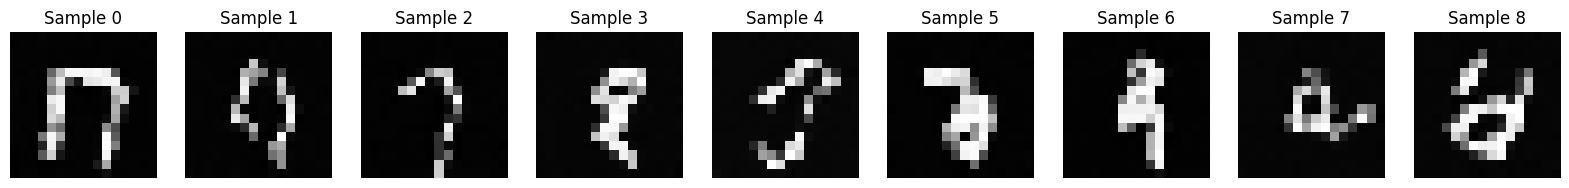

Epoch 17 loss = 0.09114453196525574


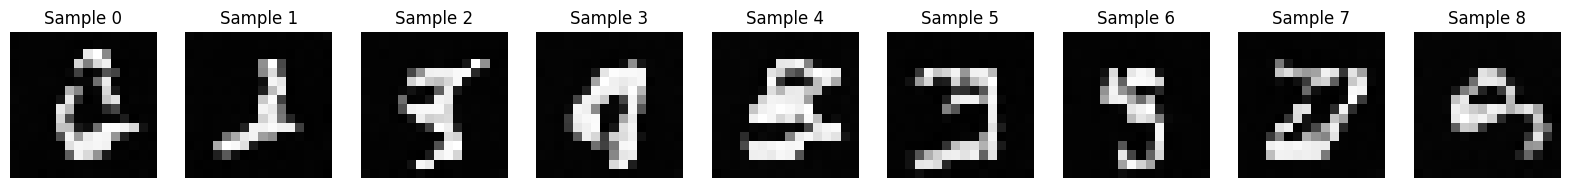

Epoch 18 loss = 0.09054978936910629


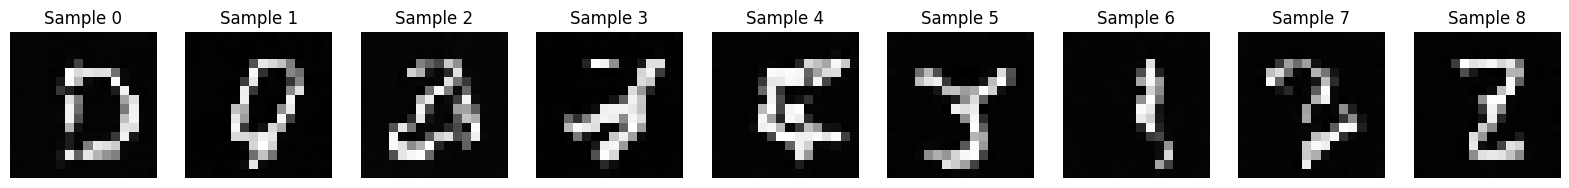

Epoch 19 loss = 0.08982416987419128


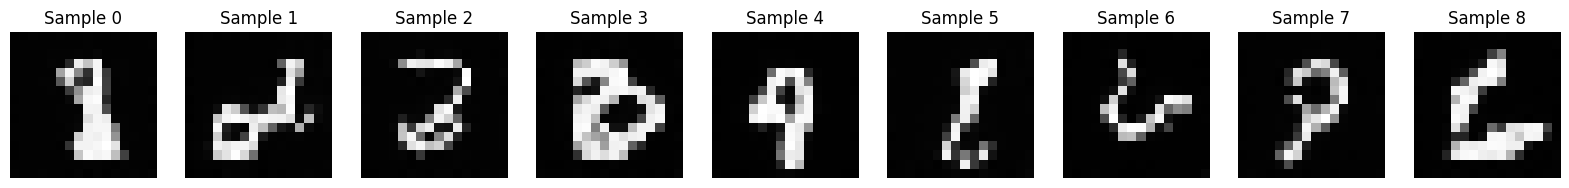

In [15]:
import torch.optim as optim

nepochs = 20
batch_size = 256


# Resize the data of 28*28 to 32*32
X = torch.tensor(x, dtype=torch.float32)
X = nn.functional.interpolate(X.view(-1, 1, 28, 28), size=(16, 16)).view(-1, 16*16)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)

for epoch in range(nepochs):
    epoch_loss = steps = 0
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
        noised, eps = noise(Xbatch, timesteps)

        noised = noised.view(-1, 1, 16, 16)
        eps = eps.view(-1, 1, 16, 16)
        timesteps = timesteps.view(-1)
        # timesteps = torch.zeros_like(timesteps)
        predicted_noise = model(noised.to(device), timesteps.to(device))
        loss = loss_fn(predicted_noise, eps.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1

    print(f"Epoch {epoch} loss = {epoch_loss / steps}")

    Xgen, Xgen_hist = sample_ddpm(model, 9, 16*16)
    Xgen = Xgen.cpu()
    fig, ax = plt.subplots(1, 9, figsize=(20,4))
    for i in range(9):
        ax[i].imshow(Xgen[i].reshape(16,16), cmap="gray")
        ax[i].set_title(f"Sample {i}")
        ax[i].axis("off")
    plt.show()

## Sampling algorithm

We will use the classic DDPM sampler, defined as follows

## Test generation

In [16]:
Xgen, Xgen_hist = sample_ddpm(model, 9, 32*32)
Xgen = Xgen.cpu()
fig, ax = plt.subplots(1, 9, figsize=(20,4))
for i in range(9):
    ax[i].imshow(Xgen[i].reshape(32,32), cmap="gray")
    ax[i].set_title(f"Sample {i}")
    ax[i].axis("off")
plt.show()

RuntimeError: The size of tensor a (36) must match the size of tensor b (9) at non-singleton dimension 0

We can also create an animation of the denoising process

## Extras: alternative sampler

In [ ]:
def sample_ddpm_x0(model, nsamples, nfeatures):
    """Sampler that uses the equations in DDPM paper to predict x0, then use that to predict x_{t-1}

    This is how DDPM is implemented in HuggingFace Diffusers, to allow working with models that predict
    x0 instead of the noise. It is also how we explain it in the Mixture of Diffusers paper.
    """
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # Predict original sample using DDPM Eq. 15
            x0 = (x - (1 - baralphas[t]) ** (0.5) * predicted_noise) / baralphas[t] ** (0.5)
            # Predict previous sample using DDPM Eq. 7
            c0 = (baralphas[t-1] ** (0.5) * betas[t]) / (1 - baralphas[t])
            ct = alphas[t] ** (0.5) * (1 - baralphas[t-1]) / (1 - baralphas[t])
            x = c0 * x0 + ct * x
            # Add noise
            if t > 1:
                # Instead of variance = betas[t] the Stable Diffusion implementation uses this expression
                variance = (1 - baralphas[t-1]) / (1 - baralphas[t]) * betas[t]
                variance = torch.clamp(variance, min=1e-20)
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
        return x

In [ ]:
Xgen = sample_ddpm_x0(model, 9, 32*32).cpu()

fig, ax = plt.subplots(1, 9, figsize=(20,4))
for i in range(9):
    ax[i].imshow(Xgen[i].reshape(32,32), cmap="gray")
    ax[i].set_title(f"Sample {i}")
    ax[i].axis("off")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (18x32 and 64x256)